

# Dataset

Trimmed [Credit risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) to have only:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

See [german-credit-data-with-risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) to see the data in Kaggle.


# Note
Install OpenMP runtime on Macbook.
```
brew install libomp
```


# Setup

In [1]:
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.feature_selection import (
    SelectKBest
)
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV,
    train_test_split
)

from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version

# Show full arrays without truncation
pd.set_option('display.max_colwidth', None)   # Prevent shortening of column values
pd.set_option('display.max_seq_items', None)  # Prevent truncation of sequences
pd.set_option('display.expand_frame_repr', False)  # Keep everything in one line per column
pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

from eda import (
    run_eda_enrich_pipeline,
    analyse_target_distribution,
    analyse_per_generation,
    analyse_per_property,
    analyse_per_gender,
    analyse_risk_per_saving,
    risk_per_generation,
    risk_per_credit_amount_bin,
    risk_heatmap,
    risk_correlation,
)
from feature_engineering import (
    run_feature_engineering_pipeline,
)
from evaluation import (
    evaluate_model
)
from psql import (
    batch_insert_with_progress,
    exists_table,
    get_all_tables,
    truncate,
    select_one,
)

# Data


In [3]:
df_original = pd.read_csv(
    "../data/raw/german_credit_data.csv",
    index_col=0,
    converters={'Risk': lambda x: {'good': 0., 'bad': 1.}[x]}
)
df_original.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0.0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1.0
2,49,male,1,own,little,NaN,2096,12,education,0.0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0.0
4,53,male,2,free,little,little,4870,24,car,1.0


In [4]:
print(df_original.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   817 non-null    object 
 5   Checking account  606 non-null    object 
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Risk              1000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 85.9+ KB
None


### Column Types

In [5]:
numeric_cols = ['Age', 'Credit amount', 'Duration']
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

### Unique Categorical Values

In [6]:
max_len = max(len(col) for col in categorical_cols)

for col in categorical_cols:
    # Convert unique values to string and join them with commas
    unique_values = df_original[col].dropna().unique()  # optional: remove NaN
    unique_str = ', '.join(str(val) for val in unique_values)
    print(f"{col:<{max_len}} : [{unique_str}]")

Sex              : [male, female]
Job              : [2, 1, 3, 0]
Housing          : [own, free, rent]
Saving accounts  : [little, quite rich, rich, moderate]
Checking account : [little, moderate, rich]
Purpose          : [radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others]


# EDA

## Target label (Risk) and imbalance


In [7]:
df, categorical_cols, numeric_cols = run_eda_enrich_pipeline(
    df=df_original, categorical_cols=categorical_cols, numeric_cols=numeric_cols
)
df.head(1)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Generation,Amount
0,67,male,2,own,NaN,little,1169,6,radio/TV,0.0,Senior,<5K


In [8]:
analyse_target_distribution(df=df)
scale = sum(df['Risk'] == False) / sum(df['Risk'] == True)
scale

2.3333333333333335

## Risk by Credit Amount

Higher the amount, higher the risk.


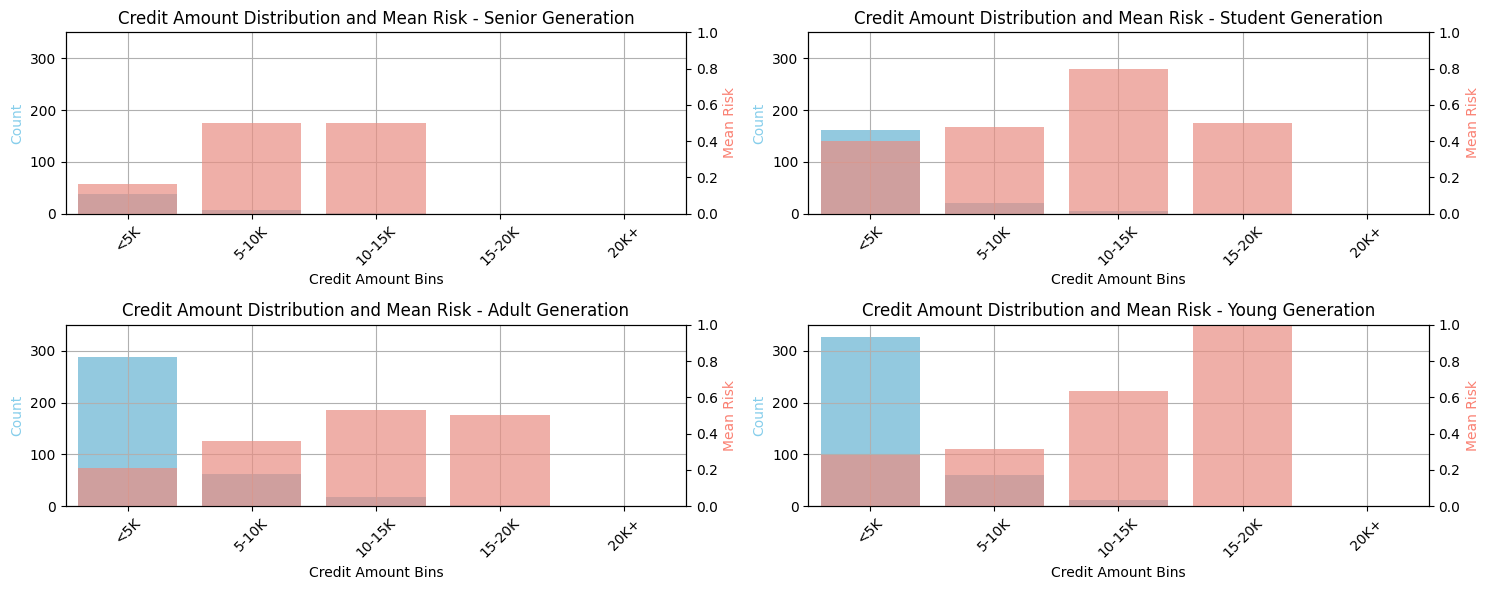

In [9]:
analyse_per_generation(df)
risk_per_credit_amount_bin(df)

# Risk Correlation

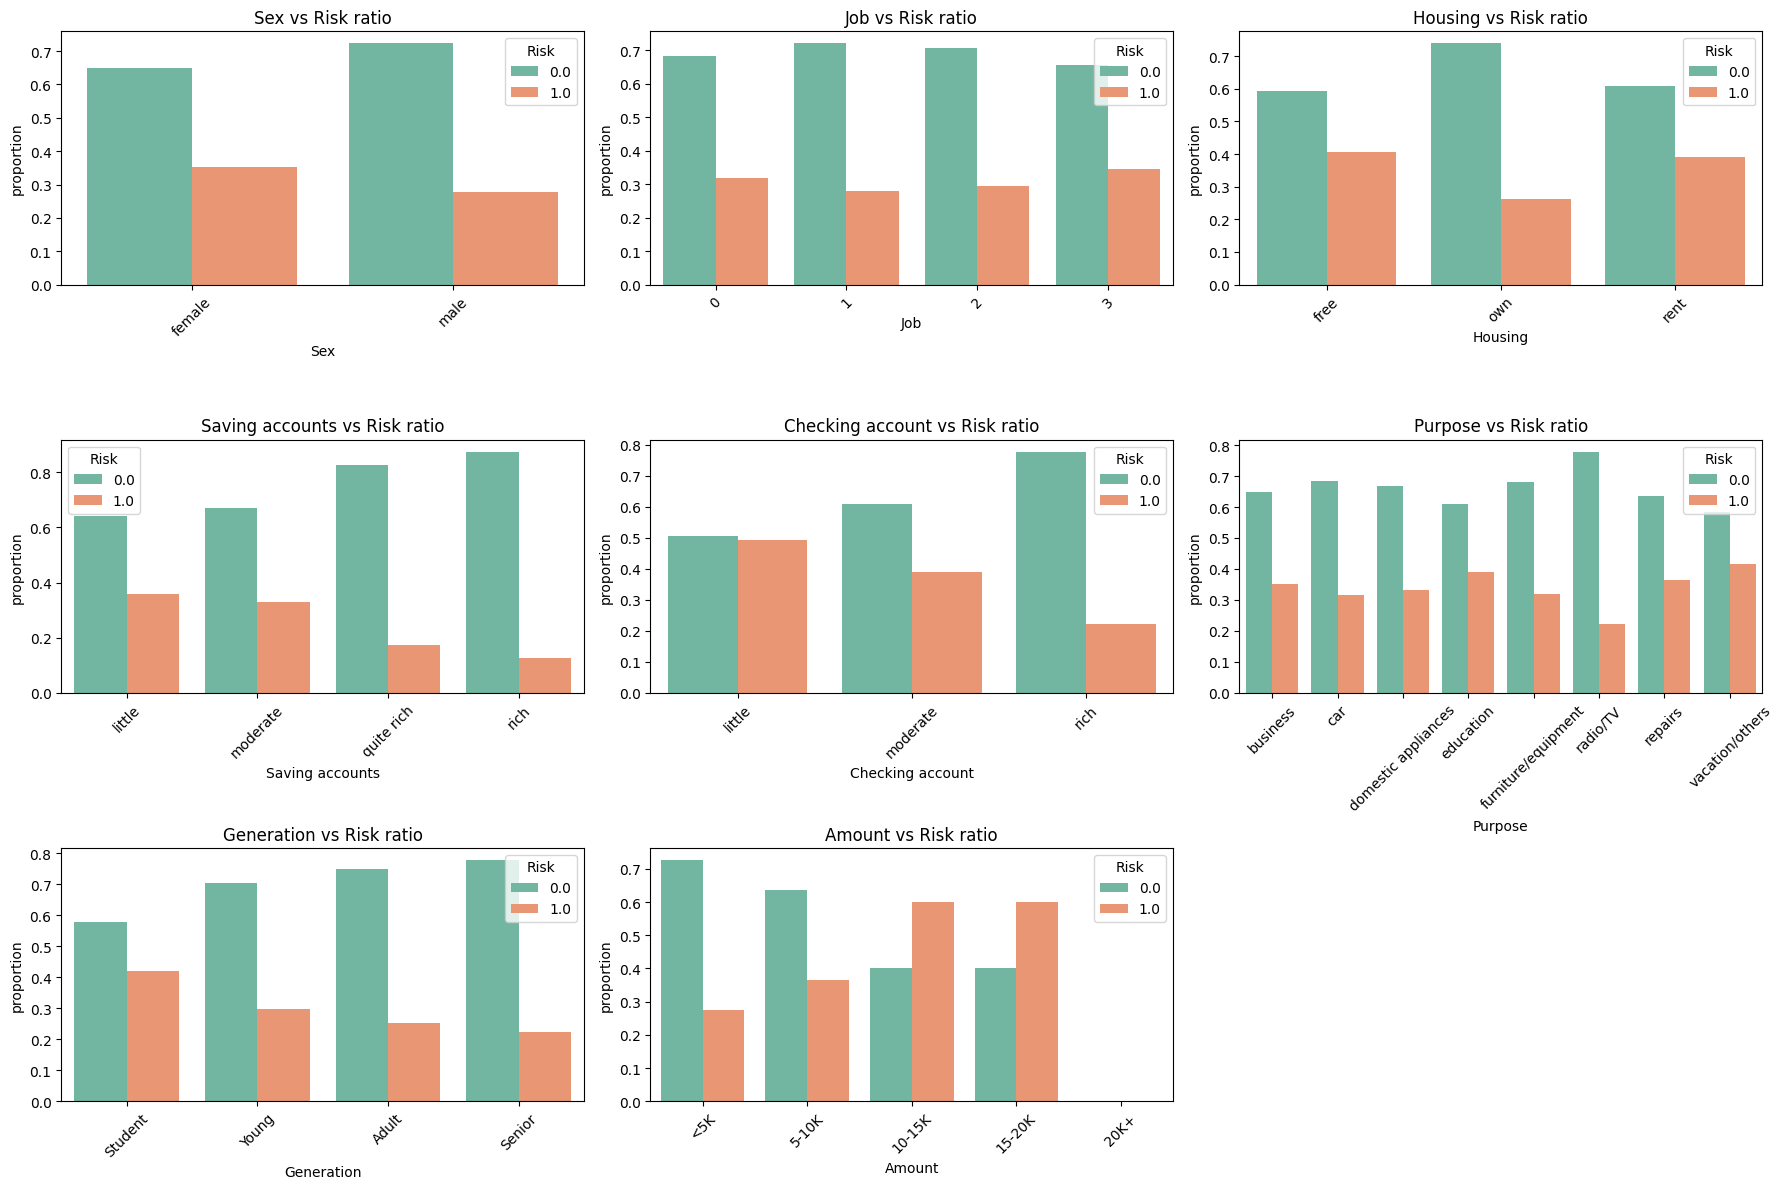

In [10]:
risk_correlation(df, categorical_cols)

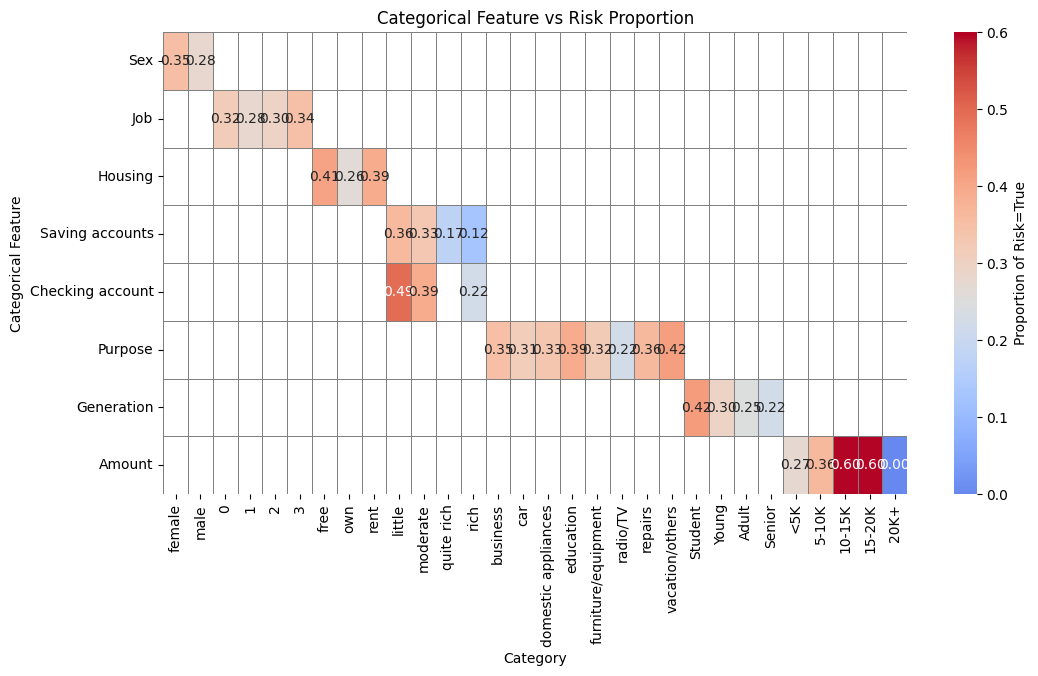

In [11]:
risk_heatmap(df, categorical_cols)

---

# Featur Engineering

In [12]:
# Looks capital letter does not work.
column_rename_remap = {
    "Risk": "risk",
    "purpose_domestic appliances": "purpose_domestic_appliances",
    "purpose_furniture/equipment": "purpose_furniture_equipment",
    "purpose_radio/TV": "purpose_radio_tv",
    "purpose_vacation/others": "purpose_vacation_others",
    "saving_accounts_quite rich": "saving_accounts_quite_rich",
    "generation_Student": "generation_student",
    "generation_Young": "generation_young",
    "generation_Adult": "generation_adult",
    "generation_Senior": "generation_senior",
    "amount_<5K": "amount_0",
    "amount_5-10K": "amount_1",
    "amount_10-15K": "amount_2",
    "amount_15-20K": "amount_3",
    "amount_20K+": "amount_4",
    "sex_male": "gender_male",
    "sex_female": "gender_female"
}

df_features = run_feature_engineering_pipeline(
    df=df,
    categorical_cols=categorical_cols,
    numeric_cols=numeric_cols,
    label_column='Risk',
    column_rename_map=column_rename_remap
)

# Features for Model Consumption

Verify the features to be consumed by the Model Training

In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   risk                         1000 non-null   float64
 1   gender_female                1000 non-null   float32
 2   gender_male                  1000 non-null   float32
 3   job_0                        1000 non-null   float32
 4   job_1                        1000 non-null   float32
 5   job_2                        1000 non-null   float32
 6   job_3                        1000 non-null   float32
 7   housing_free                 1000 non-null   float32
 8   housing_own                  1000 non-null   float32
 9   housing_rent                 1000 non-null   float32
 10  saving_accounts_little       1000 non-null   float32
 11  saving_accounts_moderate     1000 non-null   float32
 12  saving_accounts_no_inf       1000 non-null   float32
 13  saving_accounts_quite_ri

In [14]:
df_features.head()

,risk,gender_female,gender_male,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,generation_student,generation_young,generation_adult,generation_senior,amount_0,amount_1,amount_2,amount_3,amount_4
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


---


# Model Training 


In [15]:
#Creating the X and y variables
X = df_features.drop(columns=['risk'], axis=1)
y = df_features["risk"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [16]:
X.head()

,gender_female,gender_male,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,generation_student,generation_young,generation_adult,generation_senior,amount_0,amount_1,amount_2,amount_3,amount_4
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Algorithsm Comparision

Gaussian Naive Bayes gives the best recall.

In [17]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('XGB', XGBClassifier(
    scale_pos_weight = scale
)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Logistic Regression', LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)))

# evaluate each model in turn
results = []
# scoring = 'recall'
scoring = 'f1'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append((name, cv_results))
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results.sort(reverse=True, key=lambda x: x[1].mean())

XGB: 0.485379 (0.095631)
Gaussian Naive Bayes: 0.525474 (0.082965)
Logistic Regression: 0.599749 (0.080013)


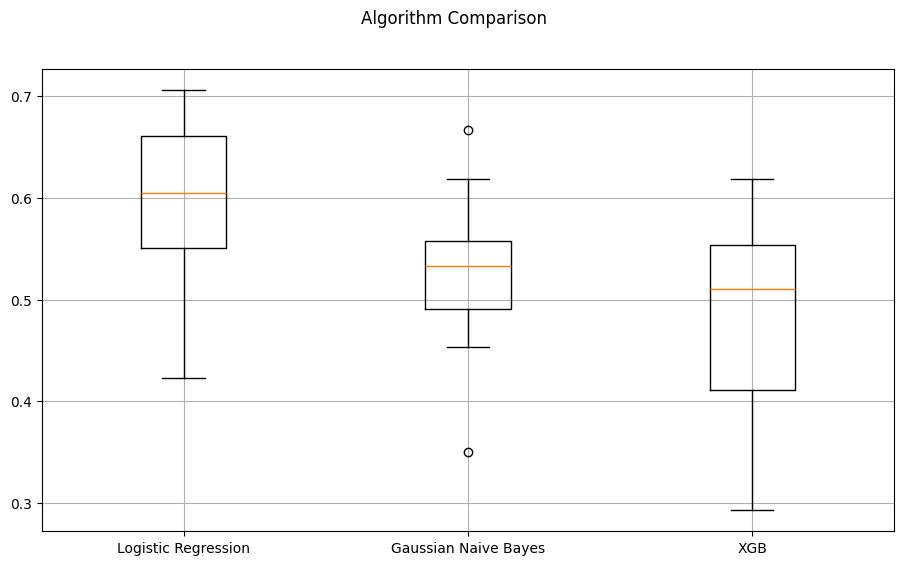

In [18]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot([x[1] for x in results])
ax.set_xticklabels([x[0] for x in results])
plt.grid()
plt.show()

# Train Models


## Logistic Regression

In [19]:
model = LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)

In [20]:
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],          # inverse regularization strength
    'penalty': ['l2'],                      # L2 regularization
    'class_weight': ['balanced', None]     # try both balanced and default
}

# GridSearchCV with ROC AUC scoring
grid_logistic = GridSearchCV(
    estimator=model,
    param_grid=param_grid_logistic,
    scoring=scoring,
    cv=5,                # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced', None], 'penalty': ['l2']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Logistic regression best score: 0.5894372219310449
{
    "C": 0.01,
    "class_weight": "balanced",
    "penalty": "l2"
}
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Best ROC: 0.5894372219310449

Logistic Regression Results:
Confusion Matrix
[[115  63]
 [ 21  51]]
Accuracy: 0.6640
Recall: 0.7083
Precision: 0.4474
F1: 0.5484
AUC: 0.7365
classification report
              precision    recall  f1-score   support

         0.0       0.85      0.65      0.73       178
         1.0       0.45      0.71      0.55        72

    accuracy                           0.66       250
   macro avg       0.65      0.68      0.64       250
weighted avg       0.73      0.66      0.68       250



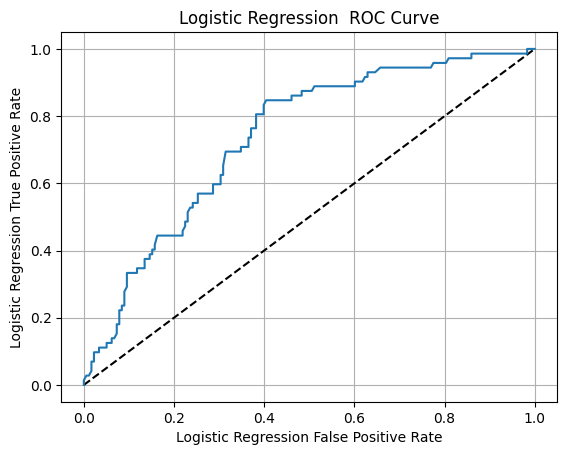

In [21]:
print(f"Logistic regression best score: {grid_logistic.best_score_}")
print(json.dumps(grid_logistic.best_params_, indent=4, default=str))

# Best parameters and score
print("Best parameters:", grid_logistic.best_params_)
print("Best ROC:", grid_logistic.best_score_)

# Evaluate on test set
best_logistic_model = grid_logistic.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)
_ = evaluate_model(best_logistic_model, X_test, y_test, "Logistic Regression")

NOTE: SKLearn Confusion Matrix format:

```
[[TN FP]
 [FN TP]]
```



## GNB

* [Scikit-Learn GridSearchCV GaussianNB](https://sklearner.com/scikit-learn-grid-search-gaussiannb/)

In [22]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6946666666666668


In [23]:
#model.fit(X_train, y_train)
# Define parameter grid
param_grid = {
    'feature_union__pca__n_components': [1, 2, 3],       # Try different PCA components
    'feature_union__select_best__k': [4, 6, 8],          # Try different number of selected features
    'logistic__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6], # GaussianNB hyperparameter
}

# Create GridSearchCV
grid_gnb = GridSearchCV(model, param_grid, cv=kfold, scoring=scoring, n_jobs=-1)

# Fit
grid_gnb.fit(X_train, y_train)

,estimator,Pipeline(step...aussianNB())])
,param_grid,"{'feature_union__pca__n_components': [1, 2, ...], 'feature_union__select_best__k': [4, 6, ...], 'logistic__var_smoothing': [1e-09, 1e-08, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformer_list,"[('pca', ...), ('select_best', ...)]"


GNB best score: 0.5516661003209277
{
    "feature_union__pca__n_components": 3,
    "feature_union__select_best__k": 4,
    "logistic__var_smoothing": 1e-09
}

Gaussian NB Results:
Confusion Matrix
[[128  50]
 [ 27  45]]
Accuracy: 0.6920
Recall: 0.6250
Precision: 0.4737
F1: 0.5389
AUC: 0.7239
classification report
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       178
         1.0       0.47      0.62      0.54        72

    accuracy                           0.69       250
   macro avg       0.65      0.67      0.65       250
weighted avg       0.72      0.69      0.70       250



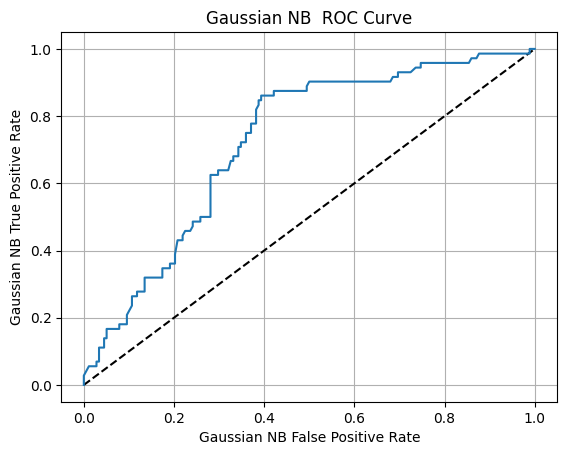

In [24]:
print(f"GNB best score: {grid_gnb.best_score_}")
print(json.dumps(grid_gnb.best_params_, indent=4, default=str))

# y_pred_gnb = model.predict(X_test)
best_gnb_model = grid_gnb.best_estimator_
y_pred_gnb = best_gnb_model.predict(X_test)

_ = evaluate_model(best_gnb_model, X_test, y_test, "Gaussian NB")

## XGB

In [25]:
param_xgb = {
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 8],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.3, 0.5]
}

#Creating the classifier
model_xg = XGBClassifier(
    random_state=2, 
    n_jobs=-1,
    scale_pos_weight=scale,
    eval_metric="auc"
)

grid_xb = GridSearchCV(model_xg, param_grid=param_xgb, cv=5, scoring=scoring)
grid_xb.fit(X_train, y_train)

[CV] END ..........C=0.01, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .................C=1, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ..............C=0.01, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ..........C=0.01, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ..............C=0.0

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.1, 0.3, ...], 'max_depth': [3, 5, ...], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'



XGBoost Results:
Confusion Matrix
[[121  57]
 [ 26  46]]
Accuracy: 0.6680
Recall: 0.6389
Precision: 0.4466
F1: 0.5257
AUC: 0.7207
classification report
              precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       178
         1.0       0.45      0.64      0.53        72

    accuracy                           0.67       250
   macro avg       0.63      0.66      0.64       250
weighted avg       0.71      0.67      0.68       250



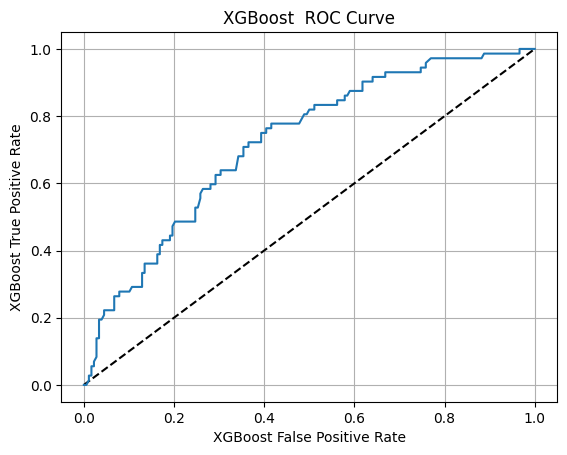

In [26]:
grid_xb.best_score_
grid_xb.best_params_

_ = evaluate_model(grid_xb.best_estimator_, X_test, y_test, "XGBoost")

In [27]:
# For XGBoost
feature_importance = grid_xb.best_estimator_.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df.sort_values('importance', ascending=False).head(10)

,feature,importance
16,checking_account_no_inf,0.122755
14,checking_account_little,0.104067
15,checking_account_moderate,0.093576
11,saving_accounts_no_inf,0.043210
7,housing_own,0.042822
26,generation_student,0.040458
3,job_1,0.040067
9,saving_accounts_little,0.033346
23,purpose_radio_tv,0.031878
5,job_3,0.031541
